In [1]:
!wget https://download.pytorch.org/tutorial/data.zip #
!unzip data.zip #

--2024-06-05 17:01:47--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.165.102.113, 3.165.102.31, 3.165.102.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.165.102.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  1.80MB/s    in 1.5s    

2024-06-05 17:01:50 (1.80 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Ital

In [1]:
import os
import unicodedata
import string

from torch import nn
import torch

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def read_text(text_path):
  with open(text_path, 'r') as archive:
    last_names = archive.read().strip().split('\n')
  last_names = [unicodedata.normalize('NFKD', last_name).encode('ascii', 'ignore') for last_name in last_names]
  for il, last_name in enumerate(last_names):
    for char in last_name.decode():
      if char not in characters:
        last_names[il] = last_name.decode().replace(char, '').encode('ascii', 'ignore')
  labels = text_path.split('/')[-1].split('.')[0]
  labels = np.repeat(labels, len(last_names))

  return last_names, labels

characters = string.ascii_letters + " -'"
root = './data/names/'
archives = sorted(os.listdir(root))

last_names, labels = [], []
length_per_class = []

for archive in archives:
  data = read_text(f'{root}{archive}')
  last_names.append(data[0])
  labels.append(data[1])
  length_per_class.append((archive, len(last_names)))

In [4]:
categories = [archive.split('.')[0] for archive in archives]

def label_to_tensor(label:str):
  return torch.LongTensor([categories.index(label)])


In [5]:
def name_to_tensor(name:str):
  name_tns = torch.zeros(len(name), len(characters))
  for k, c in enumerate(name.decode('utf-8')):
    name_tns[k][characters.index(c)] = 1

  return name_tns

In [12]:
def sample(num_sample):
  data_sample, label_sample = [], []

  for idx, category in enumerate(categories):
    num_names = len(last_names[idx])

    random_sample = np.random.choice(range(num_names), size=num_sample)
    data_sample.extend([data for i, data in enumerate(last_names[categories.index(category)]) if i in random_sample])
    label_sample.extend([data for i, data in enumerate(labels[categories.index(category)]) if i in random_sample])

  data_sample = [name_to_tensor(name) for name in data_sample]
  label_sample = [label_to_tensor(label) for label in label_sample]
  return data_sample, label_sample

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [8]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.rnn = nn.RNNCell(input_size, hidden_size)
    self.mlp = nn.Linear(hidden_size, output_size)
    self.ativacao = nn.LogSoftmax()

  def forward(self, x):
    h = torch.zeros(1, self.hidden_size).to(device)
    for char in x:
      h = self.rnn(char.unsqueeze(0), h)
    output = self.ativacao(self.mlp(h))
    return output

In [14]:
def forward(x, y, mode, epoch):
  if mode == 'test':
    model.eval()
  else:
    model.train()

  accuracy = 0
  loss_epoch = []
  for data, label in zip(x, y):

    data = data.to(device)
    label = label.to(device)

    output = model(data)
    loss = criterion(output, label)
    loss_epoch.append(loss.detach().cpu().numpy())

    t, pred = torch.max(output, axis=-1)
    accuracy += 1 if pred[0].item() == label[0].item() else 0

    if mode == 'train':
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  loss_epoch = np.asarray(loss_epoch).ravel()
  accuracy = accuracy/float(len(y))

  print('\n','*'*15 + mode + '*'*15 )
  print(f'Epoch: {epoch+1}; Loss Mean: {loss_epoch.mean():.4f}; Standard Deviation: {loss_epoch.std():.4f} Accuracy: {accuracy*100:.4f}')


  return loss_epoch.mean(), accuracy

In [45]:
model = RNN(len(characters), 28, len(labels)).to(device)
criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-7)
print(len(characters))
data_test, label_test = sample(50)
data_train, label_train = sample(50)

loss_train, loss_test = [], []
acc_train, acc_test = [],  []

for epoch in range(100):

  loss, accuracy = forward(data_train, label_train, 'train', epoch)
  loss_train.append(loss)
  acc_train.append(accuracy)

  loss, accuracy = forward(data_test, label_test, 'test', epoch)
  loss_test.append(loss)
  acc_test.append(accuracy)

55

 ***************train***************
Epoch: 1; Loss Mean: 2.9091; Standard Deviation: 0.1451 Accuracy: 3.8037

 ***************test***************
Epoch: 1; Loss Mean: 2.8837; Standard Deviation: 0.1346 Accuracy: 6.3910

 ***************train***************
Epoch: 2; Loss Mean: 2.8863; Standard Deviation: 0.1384 Accuracy: 5.5215

 ***************test***************
Epoch: 2; Loss Mean: 2.8748; Standard Deviation: 0.1285 Accuracy: 6.8922

 ***************train***************
Epoch: 3; Loss Mean: 2.8754; Standard Deviation: 0.1317 Accuracy: 6.3804

 ***************test***************
Epoch: 3; Loss Mean: 2.8660; Standard Deviation: 0.1252 Accuracy: 7.6441

 ***************train***************
Epoch: 4; Loss Mean: 2.8647; Standard Deviation: 0.1277 Accuracy: 6.8712

 ***************test***************
Epoch: 4; Loss Mean: 2.8571; Standard Deviation: 0.1242 Accuracy: 9.0226

 ***************train***************
Epoch: 5; Loss Mean: 2.8539; Standard Deviation: 0.1258 Accuracy: 7.9755

 

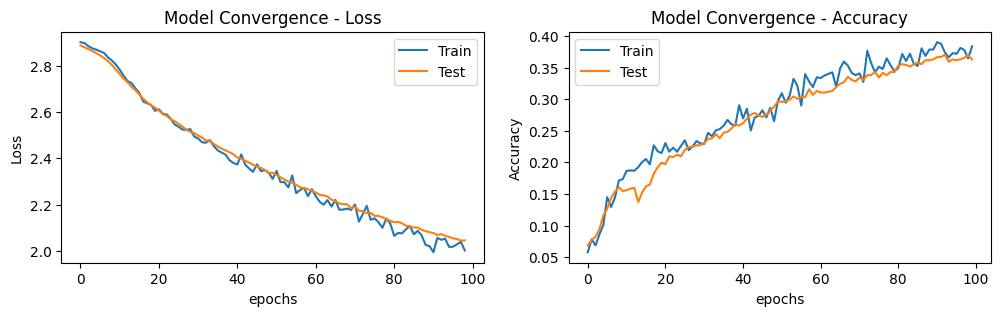

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.plot(loss_train[1:], label='Train')
ax1.plot(loss_test[1:], label='Test')
ax1.set_title('Model Convergence - Loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc_train, label='Train')
ax2.plot(acc_test, label='Test')
ax2.set_title('Model Convergence - Accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

In [ ]:
def predict(name):
  model.eval()

  tns = torch.zeros( len(name), len(characters) )
  for k, char in enumerate(name):
    idx = characters.find(char)
    tns[k, idx] = 1
  tns = tns.to(device)

  output = model(tns)
  topv, topi = output.data.topk(3, 1, True)

  print(name)
  for value, index in zip(topv[0], topi[0]):
    print('(%.2f) %s' % (value, categories[index]))
  print('\n')

predict('Mota')
predict('Kamikaze')
predict('Suarez')
predict('Scatambuli')
predict('Jacquin')